# Part1: Load

In [ ]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from numpy import arange
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_predict
from itertools import cycle
from catboost import CatBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

## Part 2: EDA

In [ ]:
train=pd.read_csv("../data/train.csv") #2000*21
test=pd.read_csv("../data/test.csv") #1000*21

FileNotFoundError: ignored

In [ ]:
df_Merge = train.append(test,sort=False)
df_Merge.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range,id
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1.0,NaN
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2.0,NaN
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2.0,NaN
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2.0,NaN
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1.0,NaN


### Merge train and test together

In [ ]:
df_Merge.isnull().sum() # no price_range column for test data; no id column for train data

battery_power       0
blue                0
clock_speed         0
dual_sim            0
fc                  0
four_g              0
int_memory          0
m_dep               0
mobile_wt           0
n_cores             0
pc                  0
px_height           0
px_width            0
ram                 0
sc_h                0
sc_w                0
talk_time           0
three_g             0
touch_screen        0
wifi                0
price_range      1000
id               2000
dtype: int64

In [ ]:
df_Merge = df_Merge.drop(['id'],axis=1) # Drop id column 

### EDA for whole data: Correlations of Each Features

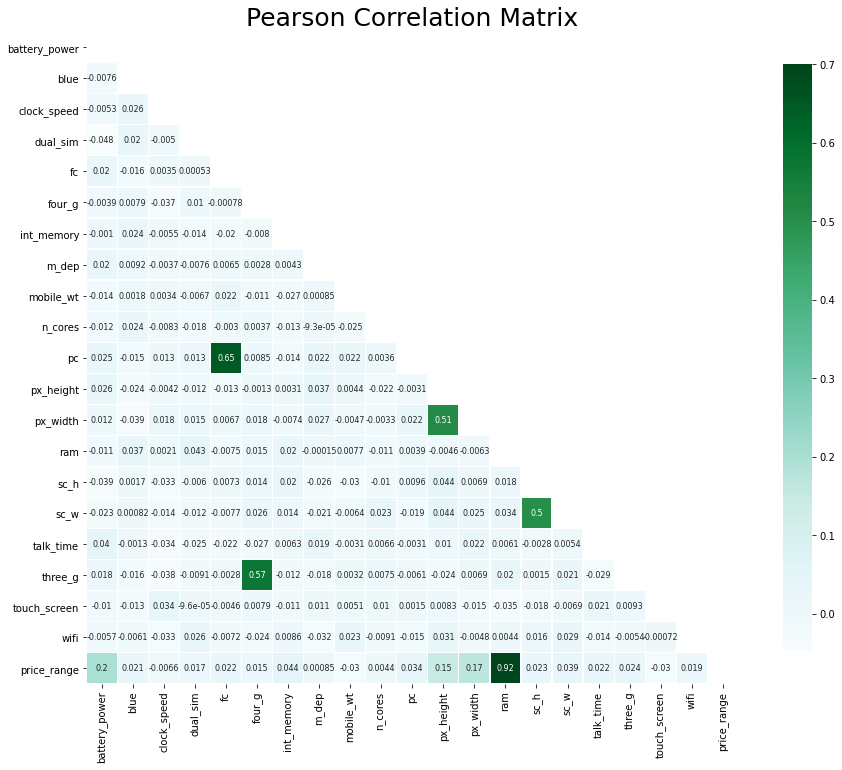

In [ ]:
features = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 
            'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 
            'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 
            'three_g', 'touch_screen', 'wifi', 'price_range']

mask = np.zeros_like(df_Merge[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df_Merge[features].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn",
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9})
plt.show()

### EDA for whole data: price_range vs. ram

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

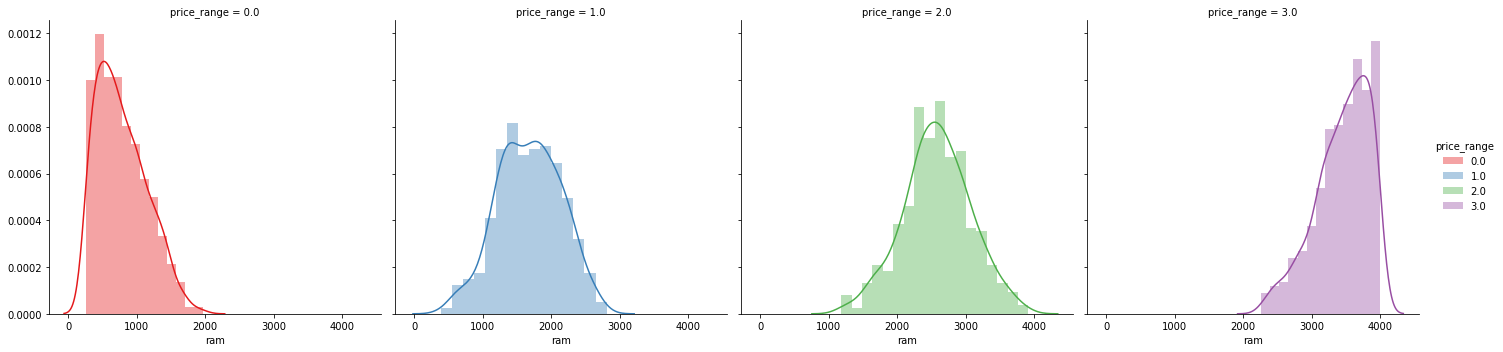

In [ ]:
g = sns.FacetGrid(df_Merge, col="price_range", hue="price_range", palette="Set1",height=5 )
g = (g.map(sns.distplot, "ram").add_legend())

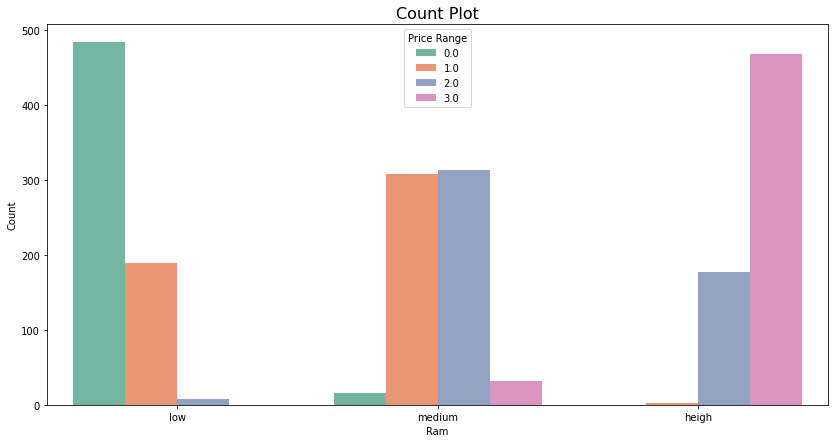

In [ ]:
df_cut = pd.DataFrame()
df_cut["Ram"] = pd.cut(df_Merge["ram"],3,labels=["low","medium","heigh"])
df_cut["Price Range"] = df_Merge["price_range"]

plt.figure(figsize=(14,7))  
sns.countplot(data=df_cut,x="Ram",hue="Price Range",palette="Set2")
plt.title("Count Plot",fontsize=16)
plt.xlabel("Ram")
plt.ylabel("Count")
plt.show()

### EDA for whole data: price_range vs. battery_power

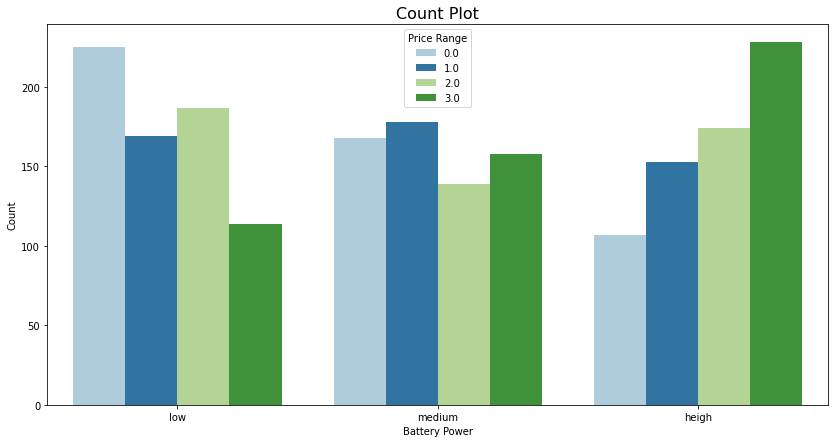

In [ ]:
df_cut["Battery Power"] = pd.cut(df_Merge["battery_power"],3,labels=["low","medium","heigh"])
plt.figure(figsize=(14,7))  
sns.countplot(data=df_cut,x="Battery Power",hue="Price Range",palette="Paired")
plt.title("Count Plot",fontsize=16)
plt.xlabel("Battery Power")
plt.ylabel("Count")
plt.show()

### Scale columns

In [ ]:
standardScaler = StandardScaler()
columns_to_scale = ['battery_power', 'clock_speed', 'int_memory', 'mobile_wt', 'px_height','px_width','ram','sc_h','sc_w','talk_time']
df_Merge[columns_to_scale] = standardScaler.fit_transform(df_Merge[columns_to_scale])

In [ ]:
df_Train=df_Merge[0:2000]
df_Test=df_Merge[2000:]

In [ ]:
df_Test = df_Test.drop(['price_range'],axis=1)

In [ ]:
X=df_Train.drop(['price_range'],axis=1)
y=df_Train.price_range

### Test-train Split

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [ ]:
x_temp_train1 = sm.add_constant(X_train)
vif_train1 = pd.DataFrame()
vif_train1["VIF Factor"] = [variance_inflation_factor(x_temp_train1.values, i) for i in range(x_temp_train1.values.shape[1])]
vif_train1["features"] = x_temp_train1.columns
vif_train1_a=vif_train1[vif_train1["VIF Factor"]<5.0]
feat_list=vif_train1_a["features"].tolist() 
# len(feat_list) = 20 # no serious multicollinearity

# Part 3: Models

## Model 1:  Naive Bayes

In [ ]:
params = {}
#gridsearch searches for the best hyperparameters and keeps the classifier with the highest recall score
skf = StratifiedKFold(n_splits=10)

nb = GridSearchCV(GaussianNB(), cv=skf, param_grid=params)

%time nb.fit(X_train, y_train)
gnb_2 = nb.fit(X_train, y_train)
y_pred_nb2 = gnb_2.predict(X_test) 

print(accuracy_score(y_test, y_pred_nb2))

CPU times: user 77.9 ms, sys: 55 ms, total: 133 ms
Wall time: 74 ms
0.8266666666666667


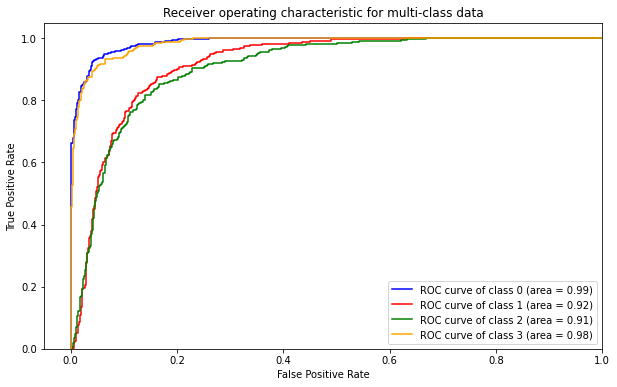

In [ ]:
X1 = X_train.to_numpy()
y1 = y_train.to_numpy()

# Binarize the output
y_bin = label_binarize(y1, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

clf = gnb_2
y_score = cross_val_predict(clf, X1, y1, cv=10 ,method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','orange'])

plt.figure(figsize=(10,6))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',linewidth=0.001)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

## Model 2: Catboost

In [ ]:
CB_Classifier = CatBoostClassifier(iterations=100,verbose=True,
                        learning_rate=0.20,depth=2,l2_leaf_reg=100,bagging_temperature=0.5)

%time CB_Classifier.fit(X_train, y_train,logging_level='Silent')
CB = CB_Classifier.fit(X_train, y_train,logging_level='Silent')

NameError: ignored

In [ ]:
pred_CB = CB.predict(X_test)
print(accuracy_score(y_test, pred_CB))

In [ ]:
X1 = X_train.to_numpy()
y1 = y_train.to_numpy()

# Binarize the output
y_bin = label_binarize(y1, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

y_score = cross_val_predict(CB, X1, y1, cv=10, method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','orange'])

plt.figure(figsize=(10,6))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',linewidth=0.001)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

## Model 3: QDA

In [ ]:
estimator_3 = QuadraticDiscriminantAnalysis()
parameters_3 = {
    'reg_param': (0.00001, 0.0001, 0.001,0.01, 0.1), 
    'store_covariance': (True, False),
    'tol': (0.0001, 0.001,0.01, 0.1), 
                   }
# with GridSearch
grid_search_qda = GridSearchCV(
    estimator=estimator_3,
    param_grid=parameters_3,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 5
)
%time grid_search_qda.fit(X_train, y_train)
qda = grid_search_qda.fit(X_train, y_train)
pred_qda =qda.predict(X_test)

print(accuracy_score(y_test, pred_qda))

CPU times: user 428 ms, sys: 51.3 ms, total: 480 ms
Wall time: 2.87 s
0.9283333333333333


In [ ]:
X1 = X_train.to_numpy()
y1 = y_train.to_numpy()

# Binarize the output
y_bin = label_binarize(y1, classes=[0, 1, 2, 3])
n_classes = y_bin.shape[1]

clf = qda
y_score = cross_val_predict(clf, X1, y1, cv=10 ,method='predict_proba')

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green','orange'])

plt.figure(figsize=(10,6))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',linewidth=0.001)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()


## Model 4: KNN

In [ ]:
def train_knn(feature_train,label_train,n_neighbors):
    # Input: feature data frame, label series, model parameters
    # Output: time to train model, trained model
    start = time.time()
    knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(feature_train,label_train)
    end = time.time()
    train_time = end-start
    return [train_time,knn]

In [ ]:
run_knn = True
feature_train,feature_test,label_train,label_test=train_test_split(train,y,test_size=0.3)

In [ ]:
def compute_metrics(feature_test,label_test,test_preds, model):
    classification_error = np.mean(np.array(test_preds) != np.array(label_test))
    accuracy = 1-classification_error
    test_probs = model.predict_proba(feature_test)[:,1]
    return [accuracy]

def test_model(model, feature_test):
    # Input: test features, a trained model
    # Output: prediction time, test predictions
    start = time.time()
    test_preds = model.predict(feature_test)
    end = time.time()
    prediction_time = end-start
    return [prediction_time,test_preds]

In [ ]:
if run_knn == True:    
    [train_time, knn] = train_knn(feature_train,label_train,n_neighbors=25)
    print('\nTraining time: {:4f} seconds'.format(train_time))

    [prediction_time,test_preds] = test_model(knn,feature_test)
    print('Prediction time: {:4f} seconds'.format(prediction_time))
    
    [accuracy] = compute_metrics(feature_test,label_test,test_preds,knn)
    print('\nAccuracy: {:4f}'.format(accuracy))
    #print('AUC: {:4f}'.format(auc))
    
    row = pd.Series({#'Feature Extraction Train Time':tm_feature_train_improved,
        #'Feature Extraction Test Time':tm_feature_test_improved,
         'Train Time':train_time,
         'Prediction Time':prediction_time,
        'Accuracy':accuracy},name='KNN')

## Model 5: LDA

In [ ]:
model = LDA(solver='eigen')
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['shrinkage'] = arange(0, 1, 0.01)
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
y_pred=search.predict(X_test)
# summarize
print(accuracy_score(y_test, y_pred))
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

## Model 6: XGB

In [74]:
model_xgb = XGBClassifier()

model_xgb.fit(X_train, y_train)
pred = model_xgb.predict(X_test)

accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print(accuracy_score(y_test, pred))

0.9116666666666666


In [75]:
# Parameter tuning to improve model performance
# Note: the process takes about an hour to run. I commented out this part of code
# def GridSearch_xgb(X_train, y_train):
    
#    params = {
#        'learning_rate': [0.01, 0.1],
#        'max_depth': [3, 5, 7, 10],
#        'min_child_weight': [1, 3, 5],
#        'subsample': [0.5, 0.7],
#        'colsample_bytree': [0.5, 0.7],
#        'n_estimators' : [100, 200, 500],
#        'objective': ['binary:logistic']
#    }

#    xgb_model = XGBClassifier()

#    gsearch = GridSearchCV(estimator = xgb_model,
#                           param_grid = params,                        
#                           cv = 5,
#                           n_jobs = -1,
#                           verbose = 1)
#    gsearch.fit(X_train,y_train)
#    y_pred=xgb1.predict(X_test)
#    acc_xgb=accuracy_score(y_test, y_pred)
#    return gsearch.best_params_ 


# GridSearch_xgb(X_train, y_train)

In [ ]:
# Incorporating the results from Gridsearch to xgb model
model_xgb_tuned = XGBClassifier(colsample_bytree=0.7,
                                learning_rate=0.1, 
                                max_depth=3, 
                                min_child_weight=5, 
                                n_estimators=500, 
                                objective='binary:logistic', 
                                subsample=0.7, 
                                seed=123, 
                                silent=True)

results = model_xgb_tuned.fit(X_train, y_train)
y_pred_tuned=model_xgb_tuned.predict(X_test)
print(accuracy_score(y_test, y_pred_tuned))

0.9283333333333333


## Model 7:

## Model 8:

## Model 9: